# 0717 CPLD Data Pre Processing
Se encarga de utilizar los datos de bitflips en la CPLD
En particular se utiliza un kernel tipo [0,1,1] para solo identificar casos en donde el error se solventa y el sub sistema se reinicia.

El output de interes seran solo estos bitnP que se evaluan esta tarea.

Se desarrollaron otras cosas como
- edge up vs edge down approach

In [1]:
import glob
import pandas as pd
from io import StringIO
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

from lib.cpld import parse_message, count_fails, read_cpld_data

In [2]:
import glob
import pandas as pd
from io import StringIO
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import logging
from typing import List, Dict, Tuple, Union, Optional

import time
import numpy as np
import re

def load_and_clean_text(filenames: List[str],
                        replacements: List[Tuple[str, str]]) -> List[str]:
    """
    Lee todos los archivos, aplica reemplazos y devuelve una lista de líneas limpias.
    """
    lines: List[str] = []
    for fn in filenames:
        raw = open(fn, 'r', encoding='utf-8', errors='ignore').read()
        for old, new in replacements:
            raw = raw.replace(old, new)
        lines.extend(raw.splitlines())
    return lines


# Compilación de la expresión regular: exactamente 4 dígitos hexadecimales


def parse_line_generic(
    raw: str,
    ts_threshold: datetime,
    file_name: str
    ) -> Tuple[
        Optional[datetime],    # time: datetime si se parsea OK, o None
        Optional[int],         # lfsr: int si OK, o None
        Dict[str, str],        # bytes_dict: { 'B0': 'FF00', … } si OK, o {}
        bool                   # valid: True si toda la línea es válida
    ]:
    """
    Parseo genérico de una línea CPLD.
    - raw: línea ya limpia (reemplazos aplicados).
    - ts_threshold: fecha mínima aceptada.
    Returns: (time, lfsr, dict_bytes, valid)
    """
    HEX_PATTERN = re.compile(r'^[0-9A-Fa-f]{4}$')

    parts = [p.strip() for p in raw.split(',')]
    # 1) Timestamp
    try:
        ts = float(parts[0])
        time = datetime.utcfromtimestamp(ts) + timedelta(hours=2)
    except Exception:
        return None, None, {}, False

    # 2) LFSR
    try:
        lfsr = int(parts[1])
    except Exception:
        return time, None, {}, False

    # 3) Extracción dinámica de bytes
    b_values = parts[2:]
    # 4) Validación de cada byte con regex
    if not b_values or any(not HEX_PATTERN.match(b) for b in b_values):
        return time, lfsr, {}, False

    # 5) Filtrado por fecha mínima
    if time < ts_threshold:
        return None, None, {}, False

    # 6) Construcción del diccionario de bytes
    bytes_dict = {f'B{i}': b for i, b in enumerate(b_values)}
    if len(bytes_dict) > 4: # no deberian haber más datos, así que estamos recibiendo lineas corruptas, mezcladas
        return time, lfsr, {}, False

    return time, lfsr, bytes_dict, True

def read_cpld_data(cpld_path: str,
                   replacements: Union[Dict[str,str], List[Tuple[str,str]]] = None,
                   debug: bool = False,
                   get_detailed_errors: bool = False
                  ) -> Union[Tuple[pd.DataFrame, pd.DataFrame],
                             Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]]:
    fnames = glob.glob(cpld_path)

    ts_threshold = datetime(2022, 1, 1) # threshold, no tendría sentido datos previo a esto
    records = []
    bad_records = []
    bad_count = 0
    drops_invalid_ts = 0
    last_ts = None

    # Preparar paths y reemplazos
    filenames = glob.glob(cpld_path)
    if isinstance(replacements, dict):
        replacements = list(replacements.items())
    replacements = replacements or [('*',''), (' #',',')]

    #---

    lines = load_and_clean_text(filenames, replacements)
    for raw in lines:
        time, lfsr, bs_dict, valid = parse_line_generic(raw, ts_threshold, filenames)
        if valid and time and lfsr is not None and bs_dict:
            last_valid_time = time
            record = {'time': time, 'lfsrTMR': lfsr, **bs_dict}
            records.append(record)
        else:
            # registrar error con último timestamp válido
            if last_valid_time:
                bad_records.append({'ts': last_valid_time})

    # DataFrame de registros válidos
    df = pd.DataFrame(records).sort_values('time').reset_index(drop=True)

    logger = logging.getLogger(__name__)
    logger.addHandler(logging.StreamHandler())
    logger.setLevel(logging.INFO)

    # DataFrame de bad records
    df_bad = pd.DataFrame(bad_records)
    if not df_bad.empty:
        df_bad['date'] = df_bad['ts'].dt.date
        df_bad['hour'] = df_bad['ts'].dt.floor('h')

    if debug:
        logger.info(f"  Registros válidos: {len(df)}")
        logger.info(f"  Registros inválidos: {len(df_bad)}")

    if get_detailed_errors and not df_bad.empty:
        errors_hora = df_bad.groupby('hour').size().reset_index(name='bad_lines')
        return df, df_bad, errors_hora
    else:
        return df, df_bad
    
df, df_bad = read_cpld_data(cpld_path = '../0_raw/Campaign2/cpld/run/cpld_data_*.dat', debug=True)
df.head()

  Registros válidos: 1030588
  Registros inválidos: 37610


,time,lfsrTMR,B0,B1,B2,B3
0,2022-09-14 11:35:48.885571,0,FF00,FF00,FF00,FF00
1,2022-09-14 11:35:49.306446,0,FF00,FF00,FF00,FF00
2,2022-09-14 11:35:49.727205,0,FF00,FF00,FF00,FF00
3,2022-09-14 11:35:50.135328,0,FF00,FF00,FF00,FF00
4,2022-09-14 11:35:50.556157,0,FF00,FF00,FF00,FF00


In [3]:
print(df.head())

                        time  lfsrTMR    B0    B1    B2    B3
0 2022-09-14 11:35:48.885571        0  FF00  FF00  FF00  FF00
1 2022-09-14 11:35:49.306446        0  FF00  FF00  FF00  FF00
2 2022-09-14 11:35:49.727205        0  FF00  FF00  FF00  FF00
3 2022-09-14 11:35:50.135328        0  FF00  FF00  FF00  FF00
4 2022-09-14 11:35:50.556157        0  FF00  FF00  FF00  FF00


In [4]:
df[df["B0"] != "FF00"]

,time,lfsrTMR,B0,B1,B2,B3
78109,2022-09-14 20:59:22.998888,0,FE00,FF00,FE00,FF00
87051,2022-09-15 12:09:15.464733,0,FE00,FB00,FF00,9F00
87052,2022-09-15 12:09:15.886347,0,FE00,FB00,FF00,9F00
87053,2022-09-15 12:09:16.337347,0,FE00,FB00,FF00,9F00
87054,2022-09-15 12:09:16.757466,0,FE00,FB00,FF00,9F00
...,...,...,...,...,...,...
818145,2022-09-20 07:49:59.721343,0,BF00,FF00,FF00,FF00
818146,2022-09-20 07:50:00.078925,0,BF00,FF00,FF00,FF00
818147,2022-09-20 07:50:00.435423,0,BF00,FF00,FF00,FF00
818148,2022-09-20 07:50:00.793475,0,BF00,FF00,FF00,FF00


In [5]:
# filtrado a solo datos donde podemos medir TMR
df = df[df["lfsrTMR"]==0]
print(df.shape)

(1010910, 6)


In [6]:
from lib.cpld import cpld_pipeline

In [7]:
import time
import numpy as np
import re


def cpld_pipeline(df, debug=False):
    # Patrón para 4 dígitos hexadecimales
    hex_pat = re.compile(r'^[0-9A-Fa-f]{4}$')
    valid_mask = ( # Filtrar el DataFrame original
        df['B0'].astype(str).str.fullmatch(hex_pat.pattern) &
        df['B1'].astype(str).str.fullmatch(hex_pat.pattern)
    )
    df_valid = df[valid_mask].reset_index(drop=True)


    # --- Medidor de tiempo total ---
    t_start = time.perf_counter()

    # ------------------------------------ Información inicial
    n_samples = len(df_valid)

    # Convertir columnas hex a uint16 a manera de tener el valor de los bits cambiados
    t1 = time.perf_counter()
    b0_int = df_valid['B0'].apply(lambda s: int(s, 16)).to_numpy(dtype=np.uint16)
    b1_int = df_valid['B1'].apply(lambda s: int(s, 16)).to_numpy(dtype=np.uint16)
    if debug:
        print(f"[0] Número total de muestras: {n_samples}")
        print(f"[1] Conversión hex→uint16: {time.perf_counter() - t1:.2f}s")

    # Aplicar máscara y extraer byte alto
    t2 = time.perf_counter()
    masked0 = ((~b0_int) & 0xFF00) >> 8
    masked1 = ((~b1_int) & 0xFF00) >> 8

    if debug: print(f"[2] Enmascarado de bytes altos: {time.perf_counter() - t2:.2f}s")
    

    t_start = time.perf_counter()

    # ---------------Desplegar bits: matriz (n_muestras × 8) para cada byte
    t3 = time.perf_counter()

    masked0_uint8 = masked0.astype(np.uint8)          # shape: (N,)
    masked1_uint8 = masked1.astype(np.uint8)          # shape: (N,)
    # expandir dimensión para que unpackbits opere por fila
    masked0_2d = masked0_uint8[:, np.newaxis]         # shape: (N,1)
    masked1_2d = masked1_uint8[:, np.newaxis]         # shape: (N,1)

    # desempacar bits little-endian a lo largo de cada fila → (N,8)
    bits0 = np.unpackbits(masked0_2d, axis=1, bitorder='little')  # shape: (N,8)
    bits1 = np.unpackbits(masked1_2d, axis=1, bitorder='little')  # shape: (N,8)

    if debug: print(f"[3] Unpack de bits por byte: {time.perf_counter() - t3:.2f}s")

    # 4. Concatenar para obtener (n_muestras × 16)
    t4 = time.perf_counter()
    bits = np.hstack([bits0, bits1]).astype(bool) 
    if debug: 
        print(f"[4] Concatenación de bits0+b1: {time.perf_counter() - t4:.2f}s")
        print(bits.shape)  

    # 5. Conteo instantáneo de fallas (popcount)
    t5 = time.perf_counter()
    fails_inst = bits.sum(axis=1)
    if debug:
        print(f"[5] Conteo instantáneo de fallas: {time.perf_counter() - t5:.2f}s")
        print(fails_inst.shape)

    # 6. Detección de resets para bias
    t6 = time.perf_counter()
    resets = (fails_inst == 0) & (np.concatenate([[False], fails_inst[:-1] > 0]))
    reset_indices = np.nonzero(resets)[0]
    if debug: print(f"[6] Detección de resets ({len(reset_indices)} encontrados): {time.perf_counter() - t6:.2f}s")

    # 7. Cálculo de acumulado ajustado
    t7 = time.perf_counter()
    cumsum = fails_inst.cumsum()
    bias_array = np.zeros_like(cumsum)
    for idx in reset_indices:
        bias_array[idx:] += cumsum[idx - 1]
    fails_acum = np.maximum.accumulate(cumsum + bias_array)
    if debug: print(f"[7] Cálculo de acumulado ajustado: {time.perf_counter() - t7:.2f}s")

    # 8. Conteo de flancos de subida (edges) y acumulado por bit
        # --> se obtiene bit_counts
    t8 = time.perf_counter()
    prev = np.vstack([np.zeros((1, 16), bool), bits[:-1]])
    edges = bits & (~prev)
    bit_counts = edges.cumsum(axis=0)
    if debug: print(f"[8] Conteo de flancos de subida por bit: {time.perf_counter() - t8:.2f}s")



    # 9. Detección de errores periódicos por bit
    t9 = time.perf_counter()

    # ---------- 1) Transiciones por bit ---------------------------
    bits_int = bits.astype(np.int8)           # 0 / 1
    # diff con padding 0 al inicio y al final para capturar flancos finales
    trans   = np.diff(bits_int, axis=0, prepend=0, append=0)   # shape (N+1,16)

    edges_up = (trans == +1)[:-1]   # volvemos a (N,16)
    edges_dn = (trans == -1)[:-1]

    # ---------- 2) Contadores acumulados --------------------------
    rising_cumsum   = edges_up.cumsum(axis=0)      # episodios que empezaron
    falling_cumsum  = edges_dn.cumsum(axis=0)      # episodios que terminaron
    
    bit_periodic = falling_cumsum   # cantidad de episodios cerrados corresponden a aquellos periodos terminados

    # ----
    if debug:
        print(f"[9] Detección de errores periódicos: {time.perf_counter() - t9:.2f}s")
        print(bit_periodic.shape)


    # --- Asignar resultados de vuelta a df_valid ---
    t10 = time.perf_counter()
    df_valid['fails_inst'] = fails_inst
    df_valid['fails_acum'] = fails_acum
    for k in range(16):
        df_valid[f'bitn{k}']  = bit_counts[:, k]
        df_valid[f'bitnP{k}'] = bit_periodic[:, k]
    if debug:
        print(f"[10] Escritura en DataFrame: {time.perf_counter() - t10:.2f}s")
        # --- Tiempo total ---
        print(f"Tiempo total aproximado: {time.perf_counter() - t_start:.2f}s")

    # Testing
    import numpy.testing as npt
    npt.assert_array_less(bit_periodic, bit_counts + 1, 
        err_msg="bitnP debería ser ≤ bitn para cada bit y muestra")

    return df_valid, (edges, resets) ,(edges_up, edges_dn), bit_periodic



In [8]:
df_valid, (edges, resets) ,(edges_up, edges_dn), bit_periodic = cpld_pipeline(df, debug=False)

In [9]:
bit_periodic

array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [ 499, 1412, 1635, ..., 2242,  401, 2239],
       [ 499, 1412, 1635, ..., 2242,  401, 2239],
       [ 499, 1412, 1635, ..., 2242,  401, 2239]], shape=(1010825, 16))

In [10]:
edges_up.sum(axis=1).cumsum(axis=0)

array([    0,     0,     0, ..., 22743, 22743, 22743], shape=(1010825,))

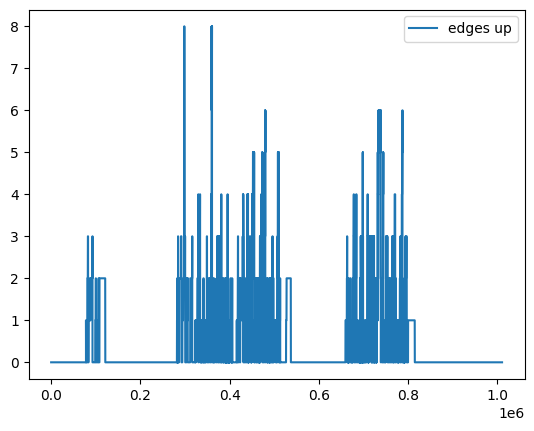

In [11]:
plt.plot(edges_up.sum(axis=1).cumsum(axis=0) - edges_dn.sum(axis=1).cumsum(axis=0), label="edges up")
#plt.plot(, label="edges down")
#plt.plot(resets.cumsum(), label="resets")
plt.legend()
plt.show()

In [12]:
resets

array([False, False, False, ..., False, False, False], shape=(1010825,))

In [13]:
edges_dn[26704]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [14]:
np.where(edges_dn)

(array([ 78110,  82728,  82728, ..., 797025, 798472, 815021],
       shape=(22743,)),
 array([ 0,  9, 14, ..., 11,  6, 10], shape=(22743,)))

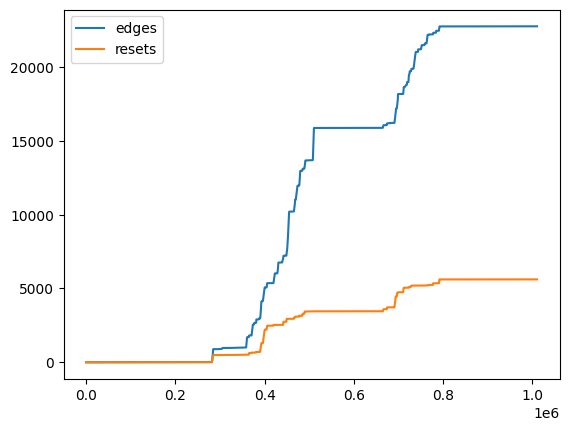

In [15]:
plt.plot(edges.sum(axis=1).cumsum(), label="edges")
plt.plot(resets.cumsum(), label="resets")
plt.legend()
plt.show()

In [18]:
df_plot

,bitn0,bitnP0,bitn1,bitnP1
time,,,,
2022-09-14 11:35:48.885571,0,0,0,0
2022-09-14 11:35:49.306446,0,0,0,0
2022-09-14 11:35:49.727205,0,0,0,0
2022-09-14 11:35:50.135328,0,0,0,0
2022-09-14 11:35:50.556157,0,0,0,0
...,...,...,...,...
2022-09-21 10:26:33.804901,499,499,1412,1412
2022-09-21 10:26:34.225785,499,499,1412,1412
2022-09-21 10:26:34.647180,499,499,1412,1412


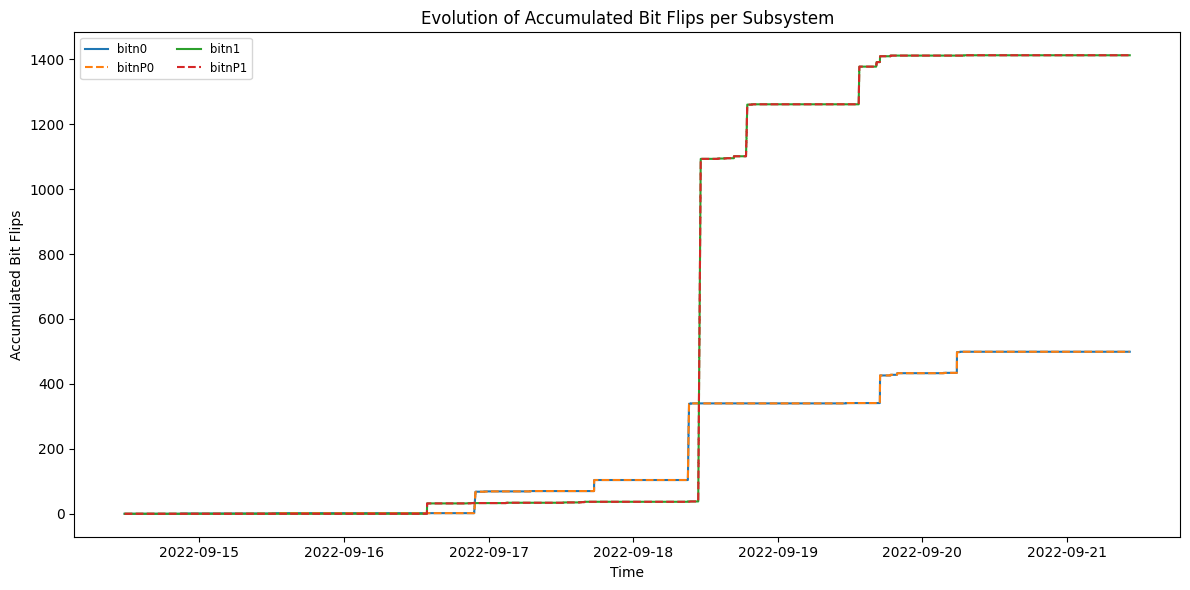

In [16]:
import matplotlib.pyplot as plt


# Assume df is the DataFrame already loaded with a datetime 'Time' column
# and bitn0..bitn15 and bitnP0..bitnP15 columns.

# Identify the bit columns
bit_columns = [col for col in df_valid.columns if col.startswith('bitn')]

bit_columns = ["bitn0", "bitnP0","bitn1", "bitnP1"]
line_styles = ['-', '--', '-', '--']

# Set Time as index for plotting
df_plot = df_valid.set_index('time')[bit_columns]

# Plot all bit error counts over time
plt.figure(figsize=(12, 6))
for idx, col in enumerate(bit_columns):
    plt.plot(df_plot.index, df_plot[col], line_styles[idx], label=col)

plt.xlabel('Time')
plt.ylabel('Accumulated Bit Flips')
plt.title('Evolution of Accumulated Bit Flips per Subsystem')
plt.legend(loc='upper left', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()
